# Assignment 3
## Implementation: EM and Gaussian mixtures

In [1]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal as mv_normal
import matplotlib.mlab as mlab
from scipy.stats import chi2
from matplotlib.patches import Ellipse

We start off by loading the training data:

In [2]:
train_data = np.loadtxt('data/EMGaussian.train')
test_data = np.loadtxt('data/EMGaussian.test')

We will define a helper function that will help us compute the Gaussian pdf. This method will be used to plot the contours as well.

In [3]:
def mv_gauss(X, Y, mu, cov):
    sigma_x = np.sqrt(cov[0,0])
    sigma_y = np.sqrt(cov[1,1])
    sigma_xy = np.sqrt(cov[0,1])
    
    mu_x = mu[0]
    mu_y = mu[1]
    
    return mlab.bivariate_normal(X, Y, sigma_x, sigma_y, mu_x, mu_y, sigma_xy)

In [4]:
# Credit to: 
# http://www.nhsilbert.net/source/2014/06/bivariate-normal-ellipse-plotting-in-python/
def plot_cov_ellipse(cov, pos, volume=.5, ax=None, fc='none', ec=[0,0,0], a=1, lw=1):
    """
    Plots an ellipse enclosing *volume* based on the specified covariance
    matrix (*cov*) and location (*pos*). Additional keyword arguments are passed on to the 
    ellipse patch artist.

    Parameters
    ----------
        cov : The 2x2 covariance matrix to base the ellipse on
        pos : The location of the center of the ellipse. Expects a 2-element
            sequence of [x0, y0].
        volume : The volume inside the ellipse; defaults to 0.5
        ax : The axis that the ellipse will be plotted on. Defaults to the 
            current axis.
    """

    def eigsorted(cov):
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:,order]

    if ax is None:
        ax = plt.gca()

    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))

    kwrg = {'facecolor':fc, 'edgecolor':ec, 'alpha':a, 'linewidth':lw}

    # Width and height are "full" widths, not radius
    width, height = 2 * np.sqrt(chi2.ppf(volume,2)) * np.sqrt(vals)
    ellip = Ellipse(xy=pos, width=width, height=height, angle=theta, **kwrg)

    ax.add_artist(ellip)

### Implementation of the K-means algorithm

In [5]:
class K_means:
    
    def __init__(self, k=4, n_dims=2):
        self.k = k
        self.n_dims = n_dims
        
    def train(self, train_data):
        # Initialize the cluster means
        self.means = np.random.rand(self.k, self.n_dims) * np.max(train_data, axis=0)
        n_iter = 0
        
        # Matrix where each row is a z_n assignment vector associated with a data point
        old_Z = np.zeros(shape=(train_data.shape[0], self.k))
        self.Z = np.zeros(shape=(train_data.shape[0], self.k))
        
        while(not self._converged(old_Z, n_iter)):
            old_Z = np.array(self.Z)
            self.Z = np.zeros(shape=(train_data.shape[0], self.k))
            
            # First phase, we evaluate the value of the latent cluster assignment variables
            for i, train_point in enumerate(train_data):                
                distances = np.linalg.norm(self.means - train_point, axis=1)**2
                self.Z[i][np.argmin(distances)] = 1 
            
            # Second phase, the values of the cluster means are computed
            self.means = self.Z.T.dot(train_data) / np.sum(self.Z.T, axis=1).reshape(self.k, 1)
            
            n_iter += 1
        
    def assign_cluster(self, data):
        
        # Will hold the cluster that each data point belongs to
        clusters = np.zeros(data.shape[0], dtype=int)
        
        for i, x in enumerate(data):            
            distances = np.linalg.norm(self.means - x, axis=1)**2
            clusters[i] = np.argmin(distances)
        
        return clusters
            
    
    # Helper function that checks the convergence of the K-means algorithm
    def _converged(self, old_Z, n_iter):
        if n_iter == 0:
            return False
        elif np.array_equal(old_Z, self.Z):
            return True
        else:
            return False

In [6]:
kmeans = K_means()

kmeans.train(train_data)
means1 = kmeans.means
clusters1 = kmeans.assign_cluster(train_data)

kmeans.train(train_data)
means2 = kmeans.means
clusters2 = kmeans.assign_cluster(train_data)

kmeans.train(train_data)
means3 = kmeans.means
clusters3 = kmeans.assign_cluster(train_data)

#### Graphical representation of the data

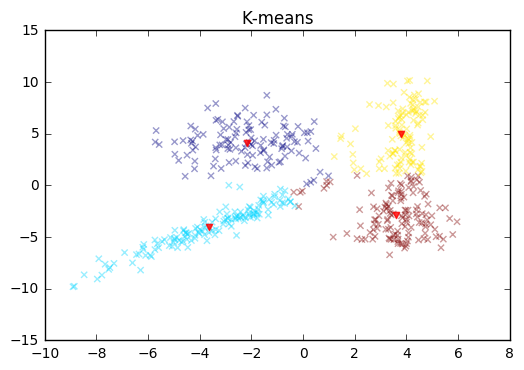

In [7]:
plt.scatter(train_data[:,0], train_data[:,1], marker='x', c=clusters1, alpha=0.4)
plt.scatter(means1[:,0], means1[:,1], marker='v', color='red', alpha=0.8)
plt.title('K-means')
plt.show()

### EM algorithm for a Gaussian mixture with covariance matrix proportional to identity matrix

In [8]:
class EM_GMM_isotropic:
    
    def __init__(self, k=4, n_dims=2):
        self.k = k
        self.n_dims = n_dims
        
    def train(self, train_data, means, clusters, MAX_ITER = 100):
        # We start off by initializing our gaussian mixture parameters with the parameters given to us
        self.means = means
        self.sigmas2 = np.ones(self.k)
        # posterior probabilities or the weights N x K matrix
        self.taus = np.zeros(shape=(train_data.shape[0], self.k))
        self.pi = np.bincount(clusters) / clusters.shape[0]        
        n_iter = 0
        
        while(n_iter < MAX_ITER):
            # E step
            for i in xrange(self.k):
                cov = self.sigmas2[i] * np.eye(self.n_dims)
                self.taus[:, i] = self.pi[i] * mv_normal.pdf(train_data, self.means[i], cov, allow_singular=True)
            
            # normalize the taus to get posterior probabilities
            self.taus = (self.taus.T / np.sum(self.taus, axis=1)).T
            
            # M step            
            # Compute the new means and covariance matrices
            for i in xrange(self.k):
                # We compute the divisor in a variable because we need it in every other computation later on
                tau_sum = np.sum(self.taus[:, i])
                
                # First the mean for cluster i
                self.means[i] = np.sum(self.taus[:, i].reshape(self.taus.shape[0], 1) * train_data, axis=0)
                self.means[i] /= tau_sum

                # Now we compute the new sigmas^2
                accum = 0
                for n in xrange(train_data.shape[0]):
                    distance = train_data[n] - self.means[i]
                    accum += self.taus[n,i] * np.linalg.norm(distance)**2
                self.sigmas2[i] = accum/( 2* tau_sum)
                
                self.pi[i] = tau_sum / train_data.shape[0]

                n_iter += 1
        
    
    def assign_cluster(self, data):
        taus = np.zeros(shape=(data.shape[0], self.k))
        for i in xrange(self.k):
            cov = self.sigmas2[i] * np.eye(2)
            taus[:, i] = self.pi[i] * mv_normal.pdf(data, self.means[i], cov, True)
                
        clusters = np.zeros(data.shape[0], dtype=int)
        for i, x in enumerate(data):
            clusters[i] = np.argmax(taus[i, :])
        return clusters
    
    def normalized_log_likelihood(self, data):
        like = np.zeros(shape=(data.shape[0], self.k))
        for i in xrange(self.k):
            cov = self.sigmas2[i] * np.eye(2)
            like[:, i] = self.pi[i] * mv_normal.pdf(data, self.means[i], cov, True)
        
        loglike = np.log(np.sum(like, axis=1))
        loglike = np.sum(loglike) / data.shape[0]
        
        return loglike

#### Graphical representation of the data

In [9]:
kmeans = K_means(k=4)
kmeans.train(train_data)
means = kmeans.means
clusters = kmeans.assign_cluster(train_data)

gmm = EM_GMM_isotropic(k=4)
gmm.train(train_data, means, clusters, MAX_ITER=500)

We plot the training data and test data together with colors to represent their estimated class

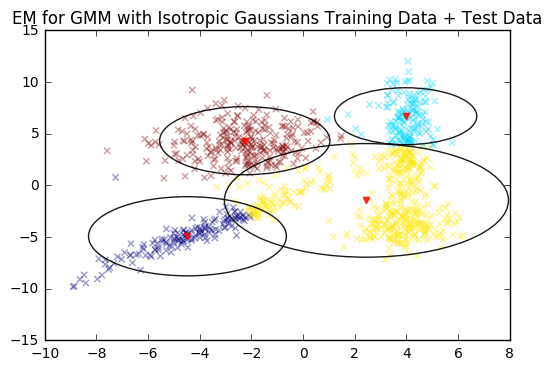

In [10]:
gmm_clusters_train = gmm.assign_cluster(train_data)
gmm_cluster_test = gmm.assign_cluster(test_data)

plt.scatter(train_data[:,0], train_data[:,1], marker='x', c=gmm_clusters_train, alpha=0.4)
plt.scatter(test_data[:,0], test_data[:,1], marker='x', c=gmm_cluster_test, alpha=0.4)
plt.scatter(gmm.means[:,0], gmm.means[:,1], marker='v', color='red', alpha=0.8)

delta = 0.5
x = np.arange(-10.0, 10, delta)
y = np.arange(-10.0, 10, delta)
X, Y = np.meshgrid(x, y)

for (mu, sigma) in zip(gmm.means, gmm.sigmas2):
    cov = sigma * np.eye(2)
    plot_cov_ellipse(cov, mu, volume=0.9, a=0.9, lw=1)

plt.title('EM for GMM with Isotropic Gaussians Training Data + Test Data')
plt.show()

We see that the ellipses containing 90% of the mass are circles. (The axes are on different scales, that is why they appear oval). This is because we assumed that the Gaussians in the mixtures were **isotropic**.

In [11]:
test_loglik = gmm.normalized_log_likelihood(test_data)
train_loglik = gmm.normalized_log_likelihood(train_data)

print 'The test log likelihood: ' + str(test_loglik)
print 'The training data log likelihood: ' + str(train_loglik) 

The test log likelihood: -5.38817674402
The training data log likelihood: -5.29104864597


### EM algorithm for a Gaussian mixture with general covariance matrix

In [12]:
class EM_GMM:
    
    def __init__(self, k=4, n_dims=2):
        self.k = k
        self.n_dims = n_dims
        
    def train(self, train_data, means, clusters, MAX_ITER = 100):
        # We start off by initializing our gaussian mixture parameters with the parameters given to us
        self.means = means
        self.covs = [np.eye(self.n_dims)] * self.k
        
        # compute the sample covariance of each cluster
        for i in xrange(self.k):
            self.covs[i] = np.cov(train_data[np.where(clusters==i)[0],:], rowvar=False) 

        # posterior probabilities or the weights N x K matrix
        self.taus = np.zeros(shape=(train_data.shape[0], self.k))
        self.pi = np.bincount(clusters) / clusters.shape[0]        
        n_iter = 0
        
        while(n_iter < MAX_ITER):            
            # E step
            for i in xrange(self.k):
                self.taus[:, i] = self.pi[i] * mv_normal.pdf(train_data, self.means[i], self.covs[i], True)
            
            # normalize the taus to get posterior probabilities
            self.taus = (self.taus.T / np.sum(self.taus, axis=1)).T
            
            # M step            
            # Compute the new means and covariance matrices
            for i in xrange(self.k):
                tau_sum = np.sum(self.taus[:, i])
                
                # First the mean for cluster i
                self.means[i] = (np.sum(self.taus[:, i].reshape(self.taus.shape[0], 1) * train_data, axis=0) / tau_sum)
                
                distance = train_data - self.means[i]
                self.covs[i] = (distance.T.dot(self.taus[:, i].reshape(self.taus.shape[0], 1) * distance) / tau_sum)
                self.pi[i] = tau_sum / train_data.shape[0]

                n_iter += 1
    
    def assign_cluster(self, data):
        taus = np.zeros(shape=(data.shape[0], self.k))
        for i in xrange(self.k):
                taus[:, i] = self.pi[i] * mv_normal.pdf(data, self.means[i], self.covs[i], True)
                
        clusters = np.zeros(data.shape[0], dtype=int)
        for i, x in enumerate(data):
            clusters[i] = np.argmax(taus[i, :])
        return clusters
    
    def normalized_log_likelihood(self, data):
        like = np.zeros(shape=(data.shape[0], self.k))
        for i in xrange(self.k):
                like[:, i] = self.pi[i] * mv_normal.pdf(data, self.means[i], self.covs[i], True)
        
        loglike = np.log(np.sum(like, axis=1))
        loglike = np.sum(loglike) / data.shape[0]
        
        return loglike
                

#### Graphical representation of the data

In [13]:
gmm = EM_GMM(k=4)
gmm.train(train_data, means, clusters, MAX_ITER=2000)

We plot the training data and test data together with colors to represent their estimated class

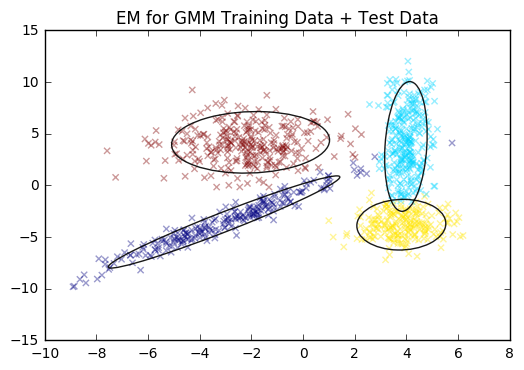

In [14]:
gmm_clusters_train = gmm.assign_cluster(train_data)
gmm_cluster_test = gmm.assign_cluster(test_data)

plt.scatter(train_data[:,0], train_data[:,1], marker='x', c=gmm_clusters_train, alpha=0.4)
plt.scatter(test_data[:,0], test_data[:,1], marker='x', c=gmm_cluster_test, alpha=0.4)

delta = 0.5
x = np.arange(-10.0, 10, delta)
y = np.arange(-10.0, 10, delta)
X, Y = np.meshgrid(x, y)

for (mu, cov) in zip(gmm.means, gmm.covs):
    plot_cov_ellipse(cov, mu, volume=0.8, a=0.9, lw=1)

plt.title('EM for GMM Training Data + Test Data')
plt.show()

We notice in this case that our model fits the data much better. This is because we removed the constraints that the Gaussians were isotropic. We assume a more general form of the covariance matrices.

In [15]:
test_loglik = gmm.normalized_log_likelihood(test_data)
train_loglik = gmm.normalized_log_likelihood(train_data)

print 'The test log likelihood: ' + str(test_loglik)
print 'The training data log likelihood: ' + str(train_loglik) 

The test log likelihood: -4.81795630691
The training data log likelihood: -4.65543134984


For EM with isotropic gaussians we get the following log likelihoods:

`
The test log likelihood: -5.38819545252
The training data log likelihood: -5.29104864112
`

For EM with Gaussians with general covariance matrices we get:

`
The test log likelihood: -4.81795630691
The training data log likelihood: -4.65543134984
`

We have that the log-likelihood is higher in the latter case. This is to be expected because a mixture with general covariance matrices will fit our data better as we can see on the scatter plots.